<a href="https://colab.research.google.com/github/Sereniiti/models-exploration/blob/develop/Ayman/Final_Bert_detailed_7_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seneriiti with Bert - example used from the link:

https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=jK-CQB9-kN99

### Dataset:
The dataset we will contains sentences with 7 categories (from very violent to excellent).


#### Under the hood, the model is actually made up of two model.
>- **DistilBERT** processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
>- The next model, a **basic Logistic Regression model** from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).


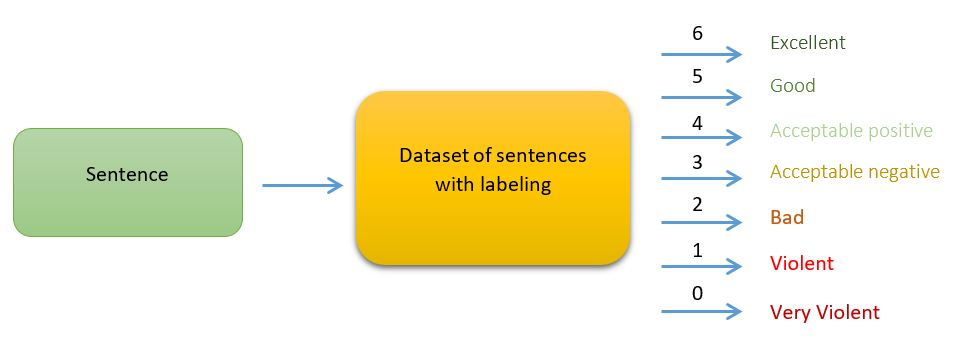
Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

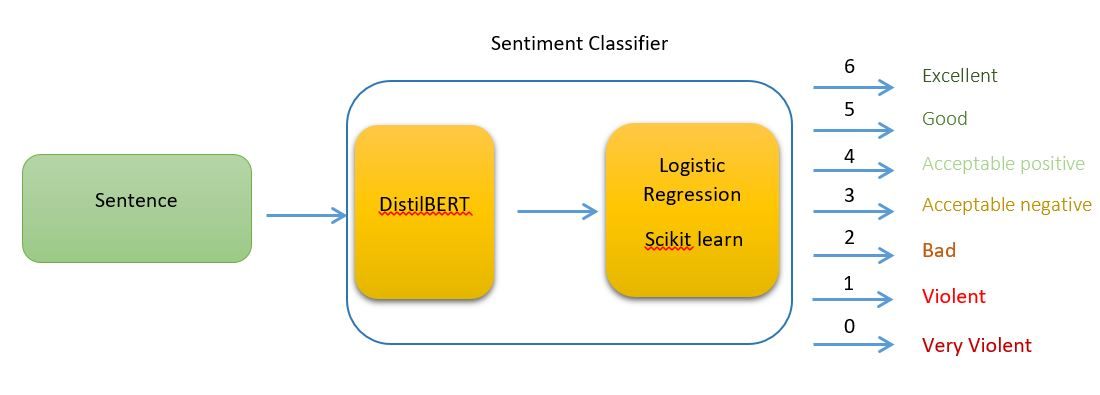

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [3]:
# install Transformers it will include packages for (huggingface-hub, sacremoses, tokenizers, transformers)
!pip install transformers

     |████████████████████████████████| 2.5MB 3.9MB/s 
     |████████████████████████████████| 3.3MB 40.2MB/s 
     |████████████████████████████████| 901kB 36.1MB/s 


### Model Training
While we’ll be using two models, we will only train the logistic regression model.
- For DistillBERT, we’ll use a model that’s already pre-trained and has a grasp on the English language.
The transformers library provides us with an implementation of DistilBERT as well as pretrained versions of the model.

## Overview
1. First use the trained distilBERT to generate sentence embeddings
2. Then We do the usual train/test split on this datase
3. Then we train the logistic regression model on the training set

### How a single prediction is calculated
Let’s try to classify the sentence “a visually stunning rumination on love”. The first step is to use the BERT tokenizer to first split the word into tokens. Then, we add the special tokens needed for sentence classifications (these are [CLS] at the first position, and [SEP] at the end of the sentence).



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [5]:
# import pandas
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data_sentences.csv')
# Dataset is now stored in a Pandas Dataframe

In [6]:
# map the labele to only 0 violent and 1 non-violent
df['ratings']=df['ratings'].map({'very violent':0, 'violent':1,'bad':2, 'acceptable negative':3,'acceptable positive':4,'good':5,'excellent':6})

In [7]:
# save only sentences and ratings column in our dataframe
df=df[['words_en','ratings']]

In [8]:
def clean_text_punc(txt):
    import string
    clean_text="".join([c for c in txt if c not in string.punctuation])
    return clean_text

In [9]:
# create new column with cleaned text
df['text_clean']=df['words_en'].apply(lambda x : clean_text_punc(x).lower())

In [10]:
# check if we have duplicated sentences showing only first 4 records
df['text_clean'].value_counts()[0:4]

youre a pain in the ass    5
i feel neglected           4
good morning               4
bitch                      4
Name: text_clean, dtype: int64

In [11]:
# drop the duplicated rows keeping only one from each
df=df.drop_duplicates(subset=['text_clean'], keep='first')

In [12]:
# data set shape
df.shape

(7266, 3)

In [13]:
df.head(6)

,words_en,ratings,text_clean
0,I feel neglected by you.,2,i feel neglected by you
1,A big boy doesn't cry,2,a big boy doesnt cry
2,"A cheetah, the fastest land animal, can run 70...",5,a cheetah the fastest land animal can run 70 m...
3,A combination of words that makes a complete s...,5,a combination of words that makes a complete s...
4,A door would have more charisma than you,0,a door would have more charisma than you
5,A feeling of gratitude is born in me.,5,a feeling of gratitude is born in me


In [14]:
# check in our data set how many record violent and non-violent to understand 
df['ratings'].value_counts()

5    2899
2    1483
1    1071
6     920
0     748
4      93
3      52
Name: ratings, dtype: int64

In [15]:
# check ratings column the unique values
df['ratings'].unique()

array([2, 5, 0, 1, 6, 4, 3])

<BarContainer object of 7 artists>

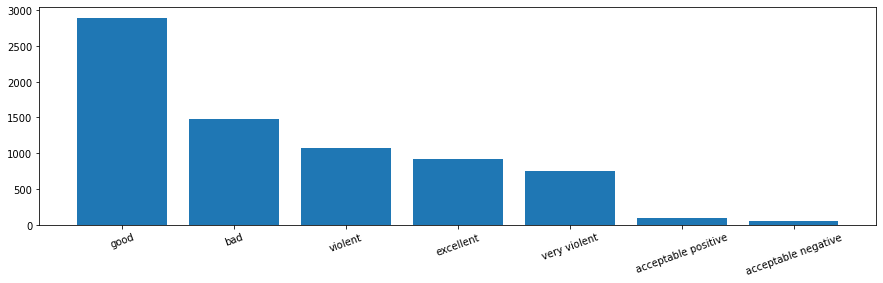

In [16]:
# show chart for the frequancy of violent and good sentences in our data set
import matplotlib.pyplot as plt
names = ['good', 'bad', 'violent', 'excellent','very violent', 'acceptable positive','acceptable negative']
values = df['ratings'].value_counts()
plt.rcParams["figure.figsize"] = (15,4)
plt.xticks(rotation = 20)
plt.bar(names, values)

Loading the Pre-trained BERT model


In [17]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT?:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [18]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

## Model #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [19]:
#Tokenization This turns every sentence into the list of ids. saving in new column name tokenized
df['tokenized'] = df['text_clean'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [20]:
df['tokenized'].head(5)

0            [101, 1045, 2514, 15486, 2011, 2017, 102]
1       [101, 1037, 2502, 2879, 2987, 2102, 5390, 102]
2    [101, 1037, 18178, 12928, 2232, 1996, 7915, 24...
3    [101, 1037, 5257, 1997, 2616, 2008, 3084, 1037...
4    [101, 1037, 2341, 2052, 2031, 2062, 25869, 296...
Name: tokenized, dtype: object

The dataset is currently a list (or pandas Series/DataFrame) of lists. Before DistilBERT can process this as input, we’ll need to make all the vectors the same size by padding shorter sentences with the token id 0

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [21]:
max_len = 0
for i in df['tokenized'][:2000].values:
    if len(i) > max_len:
        max_len = len(i)

padded= np.array([i + [0]*(max_len-len(i)) for i in df['tokenized'][:2000].values])

Our dataset is now in the padded variable, we can view its dimensions below:

In [22]:
np.array(padded).shape

(2000, 36)

**Masking**

If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [23]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 36)

## Model #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model!

>dummy sample from the web, but same concept:
<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />



The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [24]:
# Processing with DistilBERT
# We now create an input tensor out of the padded token matrix, and send that to DistilBERT

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)


In [25]:
input_ids

tensor([[  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1037,  2502,  ...,     0,     0,     0],
        [  101,  1037, 18178,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0],
        [  101,  1045,  2514,  ...,     0,     0,     0]])

In [26]:
attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [27]:
last_hidden_states[0][:,0,:]

tensor([[-8.7862e-02,  6.2111e-02, -1.2315e-01,  ..., -5.2384e-02,
          2.6557e-01,  1.8920e-01],
        [-3.1385e-01,  8.3016e-02, -1.1713e-01,  ...,  6.6377e-03,
          4.3215e-01,  4.6854e-01],
        [-3.4652e-01, -1.8579e-01,  1.1030e-02,  ..., -1.9074e-01,
          4.2118e-01,  2.3632e-01],
        ...,
        [ 3.3872e-02, -3.6119e-02, -7.0672e-03,  ...,  2.4812e-03,
          2.4267e-01,  3.0502e-01],
        [-9.3042e-02,  1.5961e-04,  5.5856e-02,  ..., -6.8167e-02,
          2.4061e-01,  2.8275e-01],
        [-3.9053e-02,  9.7117e-02, -4.1387e-02,  ..., -5.3303e-02,
          2.4340e-01,  1.8609e-01]])

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [28]:
features = last_hidden_states[0][:,0,:].numpy()

The labels indicating which sentence is positive and negative now go into the labels variable

In [ ]:
features

array([[-0.08786149,  0.06211066, -0.12315196, ..., -0.05238402,
         0.26556987,  0.18920462],
       [-0.31385162,  0.08301671, -0.11713339, ...,  0.00663789,
         0.4321484 ,  0.46854332],
       [-0.35048056, -0.20777893,  0.01780636, ..., -0.21447906,
         0.404086  ,  0.20536888],
       ...,
       [-0.04288101, -0.02361638,  0.16599448, ..., -0.0727957 ,
         0.18205824,  0.25522044],
       [-0.06198974, -0.038468  , -0.003792  , ..., -0.12664695,
         0.19811285,  0.2624396 ],
       [ 0.00692434,  0.07602084,  0.01083228, ...,  0.03200514,
         0.15249199,  0.244176  ]], dtype=float32)

In [29]:
labels = df['ratings'][0:2000]

## Model #2: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [30]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [31]:
print('len of train_features : ', len(train_features),'\nlen of test_features : ', len(test_features))

len of train_features :  1500 
len of test_features :  500


<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />


We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. LogisticRegression(C=5.2)).

In [32]:
# logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score #

model_lr = LogisticRegression()
# model fit train feature and train labels
model_lr.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# predict
predict_md=model_lr.predict(test_features)

In [34]:
# check the accuracy of the test labels with the predicted 
score=accuracy_score(predict_md,test_labels)
score

0.736

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels,predict_md) 

array([[ 16,  15,   0,   0,   0,   1,   0],
       [  6,  19,  12,   1,   0,   4,   3],
       [  3,  16,  32,   2,   0,  12,   3],
       [  0,   0,   1,   4,   0,   0,   2],
       [  0,   0,   1,   0,   2,   4,   0],
       [  1,   1,   7,   1,   0, 216,  18],
       [  0,   0,   2,   3,   0,  13,  79]])

In [36]:
from sklearn.metrics import classification_report
matrix=classification_report (predict_md, test_labels)
print(matrix)

              precision    recall  f1-score   support

           0       0.50      0.62      0.55        26
           1       0.42      0.37      0.40        51
           2       0.47      0.58      0.52        55
           3       0.57      0.36      0.44        11
           4       0.29      1.00      0.44         2
           5       0.89      0.86      0.87       250
           6       0.81      0.75      0.78       105

    accuracy                           0.74       500
   macro avg       0.56      0.65      0.57       500
weighted avg       0.75      0.74      0.74       500



In [37]:
pd.crosstab(test_labels, predict_md, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,All
True,,,,,,,,
0,16,15,0,0,0,1,0,32
1,6,19,12,1,0,4,3,45
2,3,16,32,2,0,12,3,68
3,0,0,1,4,0,0,2,7
4,0,0,1,0,2,4,0,7
5,1,1,7,1,0,216,18,244
6,0,0,2,3,0,13,79,97
All,26,51,55,11,2,250,105,500


This allows us to see that:

1. The diagonal elements show the number of correct classifications for each class: 15, 12, 32, 1, 1, 236, 75, 500 for the labels 0, 1 to 6.
2. The off-diagonal elements provides the misclassifications: for example, 3 of the label 2 were misclassified as 0 and 9 of the label 1 were misclassified as 0, none of the class 0 were misclassified as 3 or 4 or 6, etc.
3. The total number of classifications for each class in both test_labels and predict_md, from the "All" subtotals

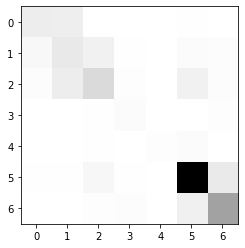

In [38]:
import matplotlib.pyplot as plt
import sklearn.metrics
 
conf = sklearn.metrics.confusion_matrix(test_labels, predict_md)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

<img src="https://jalammar.github.io/images/distilBERT/bert-training-logistic-regression.png" />

## predict test input Model #2
So how well does our model do in classifying sentences? One way is to check the accuracy against the testing dataset:

In [39]:
def predict_con(txt):
  x_new_df=pd.DataFrame({0:txt})
  
  # tokenize
  x_new_df['tokenized'] = x_new_df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  print('\ntext after tokinize : ', x_new_df['tokenized'])

  # pad the txt list to be same size of our dataset
  padded_test= np.array([i + [0]*(max_len-len(i)) for i in x_new_df['tokenized'].values])

  #If we directly send padded to BERT, that would slightly confuse it. 
  # so We create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:
  attention_mask_test = np.where(padded_test != 0, 1, 0)
  print('attention_mask shape : ', attention_mask_test.shape)

  # We now create an input tensor out of the padded token matrix, and send that to DistilBERT
  input_ids_test = torch.tensor(padded_test)  
  attention_mask_test = torch.tensor(attention_mask_test)

  with torch.no_grad():
      last_hidden_states_test = model(input_ids_test, attention_mask=attention_mask_test)
  # We'll save those in the features variable, as they'll serve as the features to our logitics regression model.
  features_test = last_hidden_states_test[0][:,0,:].numpy()
  # print('after padding : ', features_test)

  predicting= model_lr.predict(features_test)
  print('the predicted value is : ', predicting)

# 'very violent':0, 'violent':1,'bad':2, 'acceptable negative':3,'acceptable positive':4,'good':5,'excellent':6
  if (predicting == 0):
    print('very violent')
  elif (predicting == 1):
    print('violent')
  elif (predicting == 2):
    print('bad')
  elif (predicting == 3):
    print('acceptable negative')
  elif (predicting == 4):
    print('acceptable positive')
  elif (predicting == 5):
    print('good')
  elif (predicting == 6):
    print('excellent')
  else:
    print('not clear')

In [40]:
# data entry test model
#========================
#input the data for testing the model
X_new = [input('please input your text to test : ')]

predict_con(X_new)

please input your text to test : this is bad

text after tokinize :  0    [101, 2023, 2003, 2919, 102]
Name: tokenized, dtype: object
attention_mask shape :  (1, 36)
the predicted value is :  [2]
bad
